# PATCH-BASED ZERO-SHOT ANOMALY DETECTION WITH DINOV3

This notebook demonstrates a zero-shot anomaly detection and segmentation pipeline for the MVTec-AD industrial dataset. The method uses a frozen DINOv3 backbone to extract patch-level embeddings without any additional training. These embeddings are then analyzed to compute anomaly scores and generate visualizations that highlight defective regions. The notebook outlines the full workflow, including data processing, patch-based feature extraction, anomaly scoring, metric evaluation, and result visualization.

All the relevant functions are kept and explained with detail in the "functions.py" file. This notebook intends to show the most important results, importing the functions as needed.

## Imports

In [3]:
import importlib
import functions
importlib.reload(functions)
from functions import *

## Model Setup and Preprocessing

We start by initiainlizing the DINOv3 model in our device (CPU), and define the preprocessing pipeline for 240×240 input images. The preprocessing is used to transform raw images into the normalized, correctly sized format the DINOv3 model expects, ensuring consistent and meaningful patch-embedding extraction.

In [3]:
IMG_SIZE = 240

# Load model + preprocess
model, device = load_dinov3_model()
preprocess = build_preprocess(IMG_SIZE)

## Memory Bank Construction and Calibration Split

Normal (non-defective) images are split into two sets: one to build a memory bank of patch embeddings and another to estimate baseline (calibration) anomaly scores. The memory bank stores representative normal features for each selected category, enabling later comparison with test samples.

The calibration set, made of only anomaly-free images, is used to define a threshold for a later binary classification (anomalous/anomaly-free) of the images in the test set.

To conserve RAM, the notebook runs the pipeline on only four categories. Full results for all 15 categories were obtained by executing the same code in a standalone .py script rather than within Jupyter Notebook and are also shown here.

In [ ]:
# === Build memory bank on a subset of normals and get calibration scores ===

TEXTURE_CATEGORIES = ["carpet", "grid", "leather", "tile", "wood"]
OBJECT_CATEGORIES  = [
    "bottle", "cable", "capsule", "metal_nut", "hazelnut",
    "pill", "screw", "toothbrush", "transistor", "zipper",
]

ALL_CATEGORIES = TEXTURE_CATEGORIES + OBJECT_CATEGORIES

categories = ["bottle", "carpet", "metal_nut", "screw"]

memory_banks_split = {}
calib_paths_split = {}

i, l = 1, len(categories)

for cat in categories:
    train_good_dir, _, _ = get_category_paths(cat)

    img_paths = (
        glob.glob(os.path.join(train_good_dir, "*.png")) +
        glob.glob(os.path.join(train_good_dir, "*.jpg")) +
        glob.glob(os.path.join(train_good_dir, "*.jpeg"))
    )
    img_paths = sorted(img_paths)
    
    # Split train normals into:
    # - bank_paths: used to build memory bank
    # - calib_paths: used to estimate normal score distribution
    bank_paths, calib_paths = train_test_split(
        img_paths,
        test_size=0.2,      # 20% for calibration
        random_state=0,
        shuffle=True,
    )

    # --- Build memory bank from bank_paths only ---
    all_patches = []
    for p in bank_paths:
        img = Image.open(p).convert("RGB")
        patch_embeds, _, _ = extract_patch_embeddings(img,
            model=model, preprocess=preprocess, device=device, img_size=IMG_SIZE)  # [num_patches, D]
        all_patches.append(patch_embeds)

    mb = torch.cat(all_patches, dim=0)  # [M, D]
    memory_banks_split[cat] = mb
    calib_paths_split[cat] = calib_paths
    print(f"[{i}/{l}] Memory bank created. Category: {cat} | Images: {len(bank_paths)} out of {len(img_paths)} | Shape: {mb.shape}")
    i += 1

[1/4] Memory bank created. Category: bottle | Images: 167 out of 209 | Shape: torch.Size([37575, 384])
[2/4] Memory bank created. Category: carpet | Images: 224 out of 280 | Shape: torch.Size([50400, 384])
[3/4] Memory bank created. Category: metal_nut | Images: 176 out of 220 | Shape: torch.Size([39600, 384])
[4/4] Memory bank created. Category: screw | Images: 256 out of 320 | Shape: torch.Size([57600, 384])


## Calibration and Threshold Estimation

For each category, anomaly scores from calibration images are collected, and a percentile-based threshold (e.g., 99.5%) is computed. This threshold defines the boundary between normal and anomalous images during evaluation of the test set.

In [5]:
THRESH_PERCENTILE = 99.5  # can experiment with 95, 99, 99.5, 99.9, ...

import gc

category_thresholds_split = {}

for cat in categories:
    calib_scores = []
    for p in calib_paths_split[cat]:
        with Image.open(p) as img:
            img = img.convert("RGB")
            _, img_score = score_test_image(
                img,
                memory_banks_split[cat],
                model=model,
                preprocess=preprocess,
                device=device,
                img_size=IMG_SIZE,
            )
        calib_scores.append(img_score)

    calib_scores = np.array(calib_scores, dtype=np.float32)
    thr = np.percentile(calib_scores, THRESH_PERCENTILE)
    category_thresholds_split[cat] = float(thr)

    # free memory
    del calib_scores
    gc.collect()        

## Image-level Evaluation

Here we evaluate how well the method detects anomalies at the whole-image level by applying the learned thresholds and memory banks across test samples for each category.

The perfomance metrics returned by the function `evaluate_image_level_performance()` include, for each of the desired categories: ROC curves, AUROC, and confussion matrices for the previously percentile-defined threshold value. The threshold point is also marked in the ROC curves with an "x".  

In [6]:
image_level_perfomance = evaluate_image_level_performance(
    category_thresholds = category_thresholds_split,
    memory_banks = memory_banks_split,
    model = model,
    preprocess = preprocess,
    device = device,
    img_size= IMG_SIZE,
    get_category_paths = get_category_paths,
)

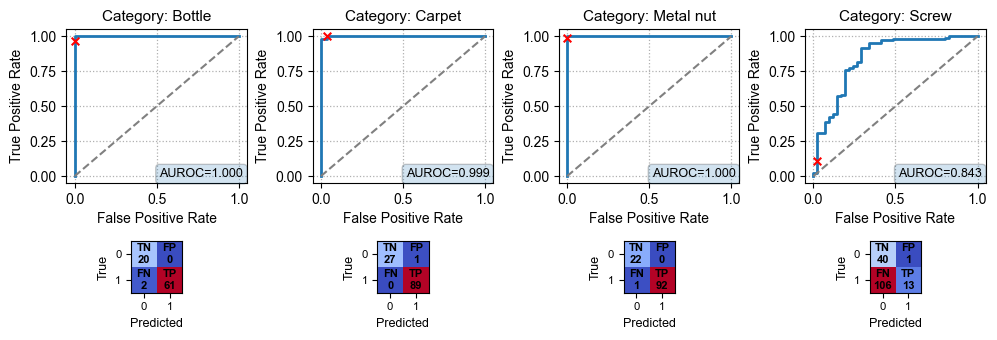

In [7]:
plot_image_level_rocs_with_confusion_matrices(image_level_perfomance)

And we visualize the results for all the 15 categories:

(np.float64(-0.5), np.float64(1124.5), np.float64(944.5), np.float64(-0.5))

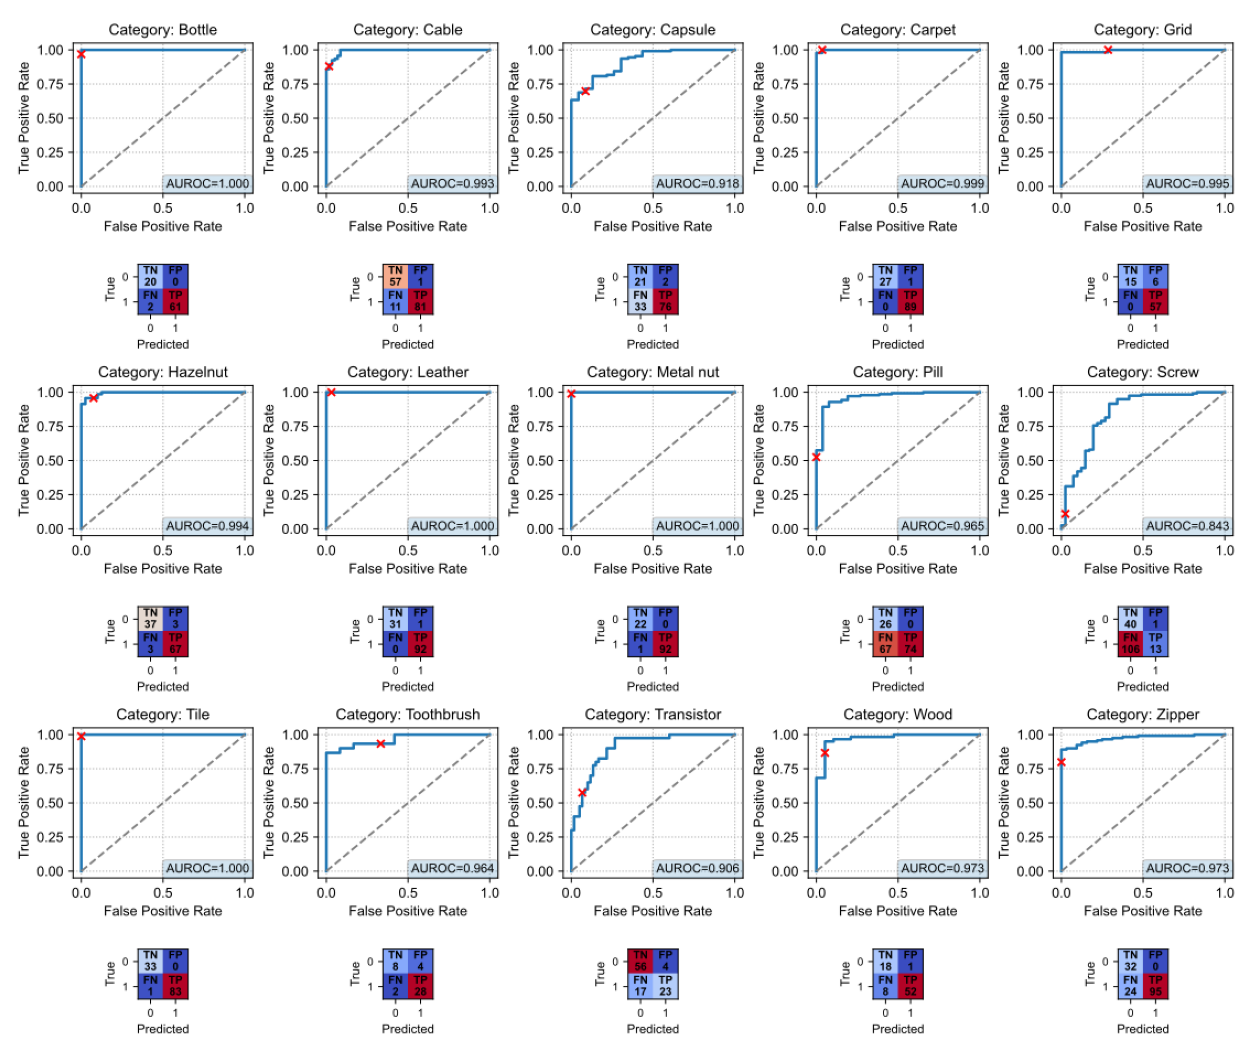

In [9]:
img = mpimg.imread("Results/figure_1.png")
plt.figure(figsize=(16, 16))
plt.imshow(img)
plt.axis("off")

## Pixel-Level Threshold Calibration

For each category, pixelwise anomaly thresholds are estimated by analyzing upsampled patch-score maps from calibration images. Multiple threshold types (maximum threshold, percentile-based and k-sigma) are computed to support pixel-level segmentation decisions.

In [8]:
pixel_thresholds = {}

MAX_THRESH = 100
PIXEL_THRESH_PERCENTILE = 99.9  # e.g. 95, 99, 99.5, 99.9, ...
K_SIGMA = 3.0                   # k for the k-sigma threshold

for cat in categories:
    mb = memory_banks_split[cat]
    calib_paths = calib_paths_split[cat]
    calib_pixel_scores_list = []

    for p in calib_paths:
        img = Image.open(p).convert("RGB")

        # patch_scores: [H_p, W_p] on device
        patch_scores, _ = score_test_image(img, memory_bank=mb, model=model, preprocess=preprocess, device=device, img_size=IMG_SIZE)
        patch_scores_np = patch_scores.detach().cpu().numpy()

        # upsample patch grid to img_size x img_size ==> pseudo pixel map
        upsampled_map = cv2.resize(
            patch_scores_np,
            (IMG_SIZE, IMG_SIZE),  # (width, height)
            interpolation=cv2.INTER_CUBIC,
        )

        calib_pixel_scores_list.append(upsampled_map.reshape(-1))

    # concat all pixels from all calib images
    calib_pixel_scores = np.concatenate(calib_pixel_scores_list).astype(np.float32)

    t1 = np.percentile(calib_pixel_scores, MAX_THRESH)
    t2 = np.percentile(calib_pixel_scores, PIXEL_THRESH_PERCENTILE)
    mu = calib_pixel_scores.mean()
    sigma = calib_pixel_scores.std()
    t3 = mu + K_SIGMA * sigma

    pixel_thresholds[cat] = [float(t1), float(t2), float(t3)]

    # free memory
    del calib_pixel_scores, calib_pixel_scores_list, upsampled_map, patch_scores_np
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

## Pixel-Level Evaluation

Here we assess how effectively the method localizes anomalous regions within each image by applying the pixelwise thresholds derived from calibration data.

The perfomance metrics returned by the function `evaluate_image_level_performance()` include, for each of the desired categories: ROC curves, AUROC, PRO curves, AUPRO, and the position in such curves for the threshold obtained with the three threshold estimation methods:
* The triangle corresponds to maximum threshold.
* The cross corresponds to the p-quantile threshold (here using q=99.9).
* The square corresponds to the k-Sigma threshold.

In [9]:
pixel_level_performance = evaluate_pixel_level_performance(
    pixel_thresholds=pixel_thresholds,
    memory_banks=memory_banks_split,
    model=model,
    preprocess=preprocess,
    device=device,
    img_size=IMG_SIZE,
    get_category_paths=get_category_paths,
)

g:\Other computers\My Laptop\Escritorio\DTU\3rd Semester\02456 Deep Learning\Final Project\functions.py:861: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_roc.scatter(
g:\Other computers\My Laptop\Escritorio\DTU\3rd Semester\02456 Deep Learning\Final Project\functions.py:899: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_pro.scatter(


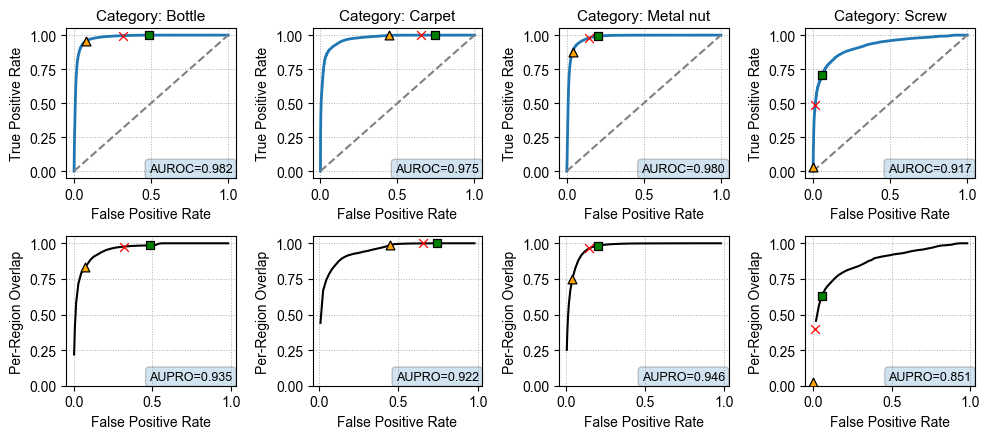

In [10]:
plot_pixel_level_roc_and_pro(pixel_level_performance)

And we visualize the results for all the 15 categories:

(np.float64(-0.5), np.float64(1124.5), np.float64(1214.5), np.float64(-0.5))

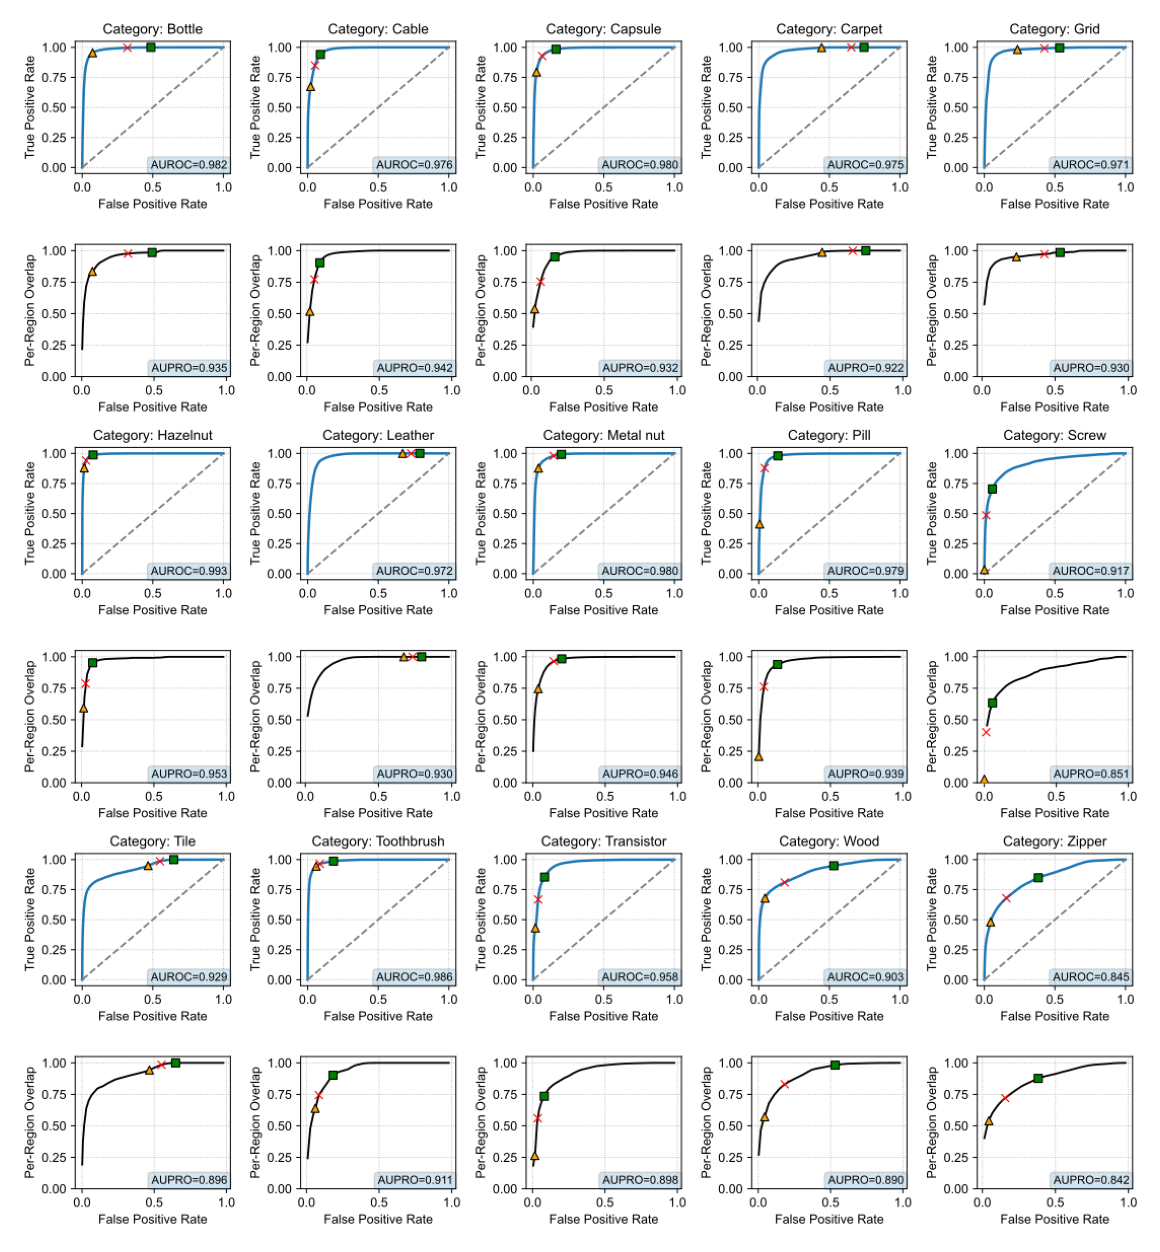

In [8]:
img = mpimg.imread("Results/figure_2.png")
plt.figure(figsize=(16, 16))
plt.imshow(img)
plt.axis("off")

## Performance Metrics Summary

The following table summarizes all the mentioned performance metrics for the selected categories. Non-selected categories will show "N/A".

In [11]:
df = build_simple_table(image_level_perfomance, pixel_level_performance)
df

,Category,Image_AUROC,Image_F1,Pixel_AUROC,Pixel_AUPRO,Pixel_F1
0,Carpet,0.999197,0.994413,0.974668,0.922469,0.068014
1,Grid,N/A,N/A,N/A,N/A,N/A
2,Leather,N/A,N/A,N/A,N/A,N/A
3,Tile,N/A,N/A,N/A,N/A,N/A
4,Wood,N/A,N/A,N/A,N/A,N/A
5,Bottle,1.0,0.983871,0.981553,0.934639,0.60385
6,Cable,N/A,N/A,N/A,N/A,N/A
7,Capsule,N/A,N/A,N/A,N/A,N/A
8,Hazelnut,N/A,N/A,N/A,N/A,N/A
9,Metal nut,1.0,0.994595,0.979763,0.946061,0.813812


The full table is: 

(np.float64(-0.5), np.float64(804.5), np.float64(395.5), np.float64(-0.5))

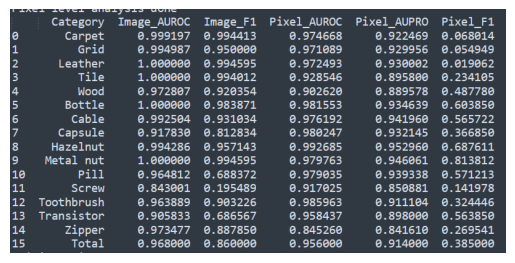

In [26]:
img = mpimg.imread("Results/Table.png")
plt.imshow(img)
plt.axis("off")

## Pixel-Level Visualization of Sample Anomalies

A set of representative defective samples is selected across the categories, defect type and threshold method. The function `plot_multiple_pixel_rows()` visualizes each case by showing the original image, its anomaly map, and the corresponding thresholded segmentation, allowing qualitative comparison of pixel-level detection performance.

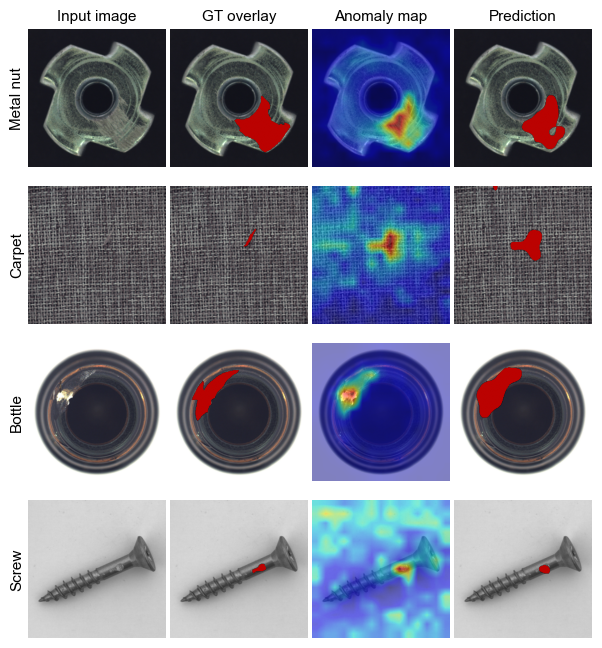

In [12]:
rows = [
    dict(
        category="metal_nut",
        defect_type="scratch",
        image_index=1,
        threshold_key="t1",
    ),
    dict(
        category="carpet",
        defect_type="thread",
        image_index=1,
        threshold_key="t2",
    ),
    dict(
        category="bottle",
        defect_type="broken_large",
        image_index=4,
        threshold_key="t1",
    ),
    dict(
        category="screw",
        defect_type="scratch_neck",
        image_index=4,
        threshold_key="t2",
    )
]

plot_multiple_pixel_rows(
    rows=rows,
    memory_banks=memory_banks_split,
    pixel_level_banks=pixel_level_performance,
    model=model,
    preprocess=preprocess,
    device=device,
    img_size=IMG_SIZE,
    get_category_paths=get_category_paths,
)


It is important to note that these heatmaps and anomaly segmentation maps are produced entirely from DINOv3's embeddings and there was no training or fine-tuning involved (zero-shot). The results, nevertheless, are remarkably effective.

We finish the notebook by giving analysing the cases above:
* **Metal nut**: The model highlights a large defective region consistent with the ground-truth mask. Heatmap activation aligns well with the damaged area.
* **Carpet**: The anomaly is small and subtle. The heatmap shows a localized activation that corresponds to the thread defect. The predicted mask captures the region reasonably well.
* **Bottle**: The defect is larger and clearly visible. The heatmap strongly activates around the anomaly, and the predicted mask matches the defective area closely.
* **Screw**: The anomaly is small and located near the screw’s neck. The heatmap shows scattered noise, but the predicted mask still isolates the correct defective spot.